In [1]:
import gc, os, random, pickle
import pandas as pd
import numpy as np
import scipy
from scipy import stats

# 导入模型和sklearn
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score,auc, log_loss
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tqdm import tqdm 

pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)
    
'''seaborn and matplotlib'''
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

'''plotly'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

'''按markdown格式展现数据'''
init_notebook_mode(connected = True)
from IPython.display import Markdown

def bold(string):
    display(Markdown(string))

In [2]:
train = pd.read_csv('./jet_simple_data/simple_train_R04_jet.csv')
test =pd.read_csv('./jet_simple_data/simple_test_R04_jet.csv')

In [ ]:
print(train.shape, test.shape)

In [4]:
train.head()

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label
0,17a0a1f19a7f43558cb9cca517b6e198,21,-288.5120,0.30256,1.839620,289.0660,17.78110,410e86bc0457482d9d6f81cd2d95ccf0,1
1,36d1005f56d343d5a09513cb7a4ead61,26,-158.4480,2.13265,-16.283400,159.7180,11.58480,6f7bf9104f8c4a619eedd129d5ce3dcb,5
2,a82071a653304481979b5dfb8eb0da47,27,-104.1430,-37.26720,-20.658500,113.3200,13.42170,4ee694b125c944c1a4560a20b79ccbe3,4
3,d3b2474fe3ba43e2b02b918adf8bbd98,17,284.8090,1.31363,0.562324,286.0620,26.71040,a0543408ffe140979e03b063fd7129c5,1
4,e46253f34c93428cb91fe0c7fc03c430,12,-38.3067,15.60110,-7.581700,42.2007,3.55142,a4b2679fd14a418c8d21fcaf2e32be8e,4


In [5]:
test.head()

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id
0,cb3b5c6ea5e441e9b425fc1e6a4a00e6,23,-86.9773,0.268724,6.699850,87.5486,7.39969,63d5670e5c514f00b64c0329382af524
1,838bf5c3f9bc4a2194f51b3c57f403cd,26,72.0487,-7.242040,-0.515331,73.2549,11.06970,8ddc9b4f189d42d08bde2936914341ed
2,fbc245d8b90b4a5d804880e097244a67,6,21.4055,-0.877366,-1.224690,21.6806,3.09542,e9a3a2a70f8f45999a0526c9b7538670
3,f4c5dffa513a443fbbd27ca4c0fbe44f,7,-12.1341,-3.029840,-4.381850,13.3144,1.28673,e8f3cdee49b043a08be537c763e8e2f4
4,74b105d4cb654c4d94da3fb88c8cd6a7,17,133.2230,203.498000,-107.776000,266.3240,12.38630,757c56889e744eff99611d8313ca31f7


In [6]:
print(train['label'].value_counts())
# 21 多一点外，其他几类基本上差不多

21    358600
1     261207
4     260186
5     254562
Name: label, dtype: int64


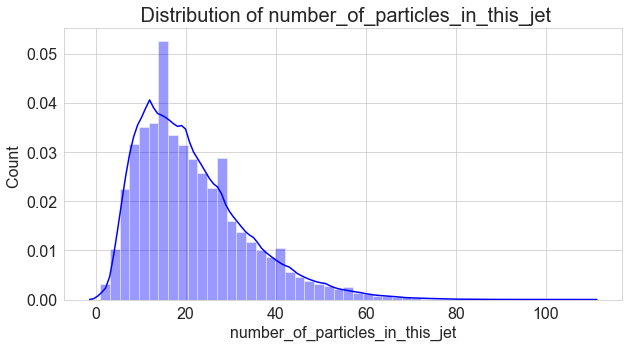

In [7]:
def distplot(variable, color):
    global ax
    font_size = 16
    title_size = 20
    plt.rcParams['figure.figsize'] = (10, 5)
    ax = sns.distplot(variable, color = color)
    plt.xlabel('%s' %variable.name, fontsize = font_size)
    plt.ylabel('Count ', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.title(' Distribution of '+'%s' %variable.name, fontsize = title_size)
    plt.show()
distplot(train['number_of_particles_in_this_jet'], 'blue')

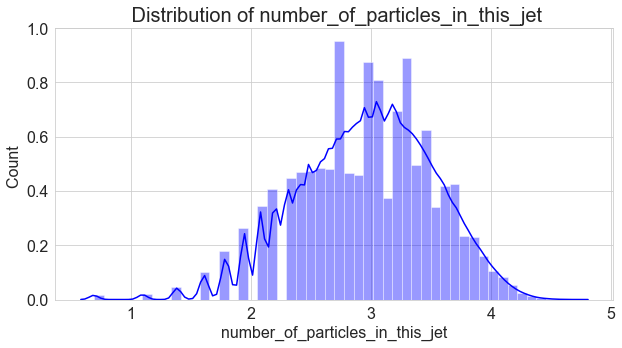

In [9]:

distplot(np.log1p(train['number_of_particles_in_this_jet']), 'blue')


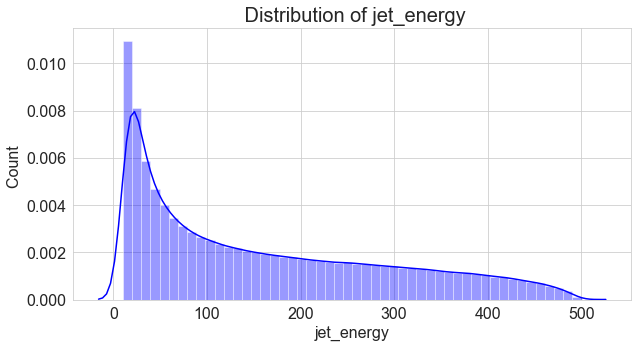

In [10]:
distplot(train['jet_energy'], 'blue')

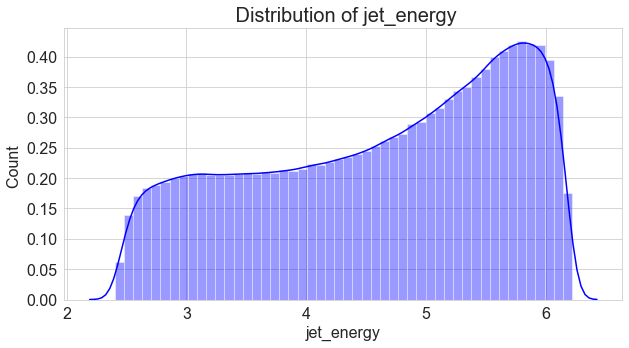

In [12]:
 distplot(np.log1p(train['jet_energy']), 'blue')

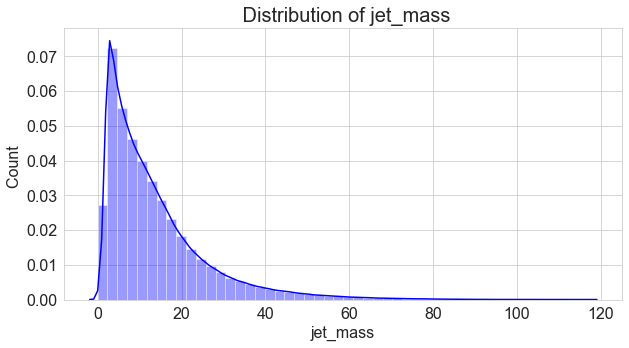

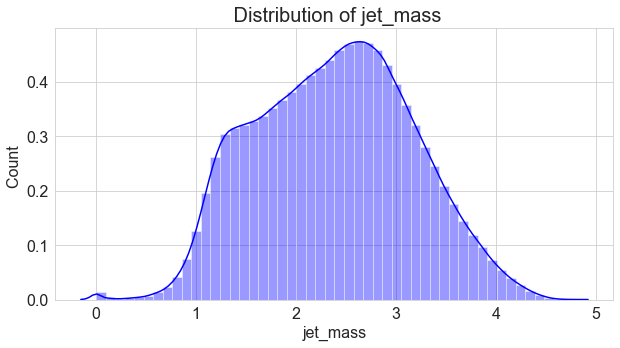

In [14]:
distplot(train['jet_mass'], 'blue')
distplot(np.log1p(train['jet_mass']), 'blue')

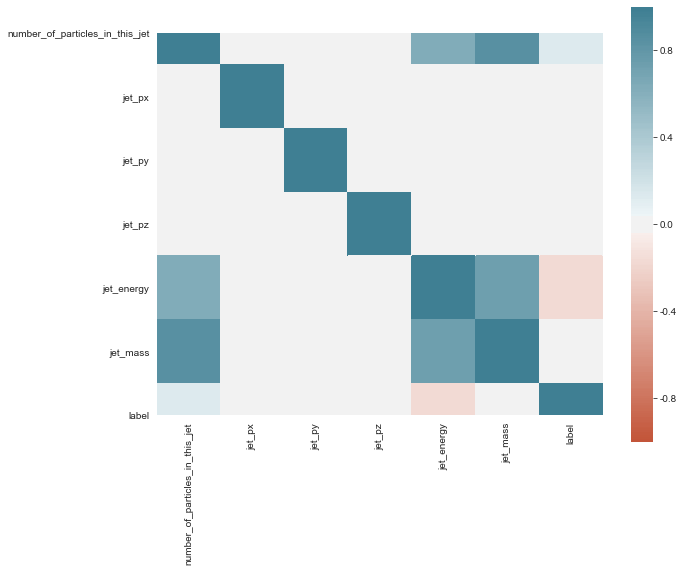

In [15]:
plt.rcParams['figure.figsize'] = (10,8)
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0,
            square=True, cmap = sns.diverging_palette(20, 220, n=200))
plt.show()

In [4]:
from sklearn.preprocessing import LabelEncoder
object_col = ['label']
for i in tqdm(object_col):
    lbl = LabelEncoder()
    train[i] = lbl.fit_transform(train[i].astype(str))

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


In [5]:
print(train['label'].value_counts())

1    358600
0    261207
2    260186
3    254562
Name: label, dtype: int64


In [6]:
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, auc
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm


params = {
            'boosting_type': 'gbdt',
            'objective': 'multiclass',
            'num_class':4,
#             'metric': {'multi_logloss'},
            'subsample': 0.25,
            'subsample_freq': 1,
            'learning_rate': 0.3,
            'num_leaves': 20,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

folds = 5
seed = 2019
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

models = []
cv_score = []
test_pred = np.zeros((test.shape[0],))
train_features = ['number_of_particles_in_this_jet','jet_px', 'jet_py', 'jet_pz', 'jet_energy', 'jet_mass']
for index, (train_index, test_index) in enumerate(kf.split(train, train['label'])):
    print(index)
    
    train_x, test_x, train_y, test_y = train.iloc[train_index],train.iloc[test_index], train['label'].iloc[train_index], train['label'].iloc[test_index]
    lgb_model = lgb.train(params, 
                    train_set = lgb.Dataset(train_x[train_features], train_y), 
                    valid_sets = [lgb.Dataset(train_x[train_features], train_y), 
                                  lgb.Dataset(test_x[train_features],test_y)],
                    num_boost_round=50, 
                    verbose_eval=50
        )
    y_pred = lgb_model.predict(test_x[train_features], num_iteration=lgb_model.best_iteration)
    y_pred = [list(x).index(max(x)) for x in y_pred]
#     print(y_pred)
#     print(test_y)
    print( "test auc",  accuracy_score(test_y , y_pred))
    
#     cv_score.append(roc_auc_score(test_y[],y_val))
#     print("cv_score:", cv_score[index])
#     test_pred += lgb_model.predict(test[train_features], num_iteration=lgb_model.best_iteration) / folds
    

0
[50]	valid_0's multi_logloss: 1.24904	valid_1's multi_logloss: 1.25306
test auc 0.4273972844217828
1
[50]	valid_0's multi_logloss: 1.24939	valid_1's multi_logloss: 1.25199
test auc 0.42762392469327315
2
[50]	valid_0's multi_logloss: 1.2491	valid_1's multi_logloss: 1.25329
test auc 0.4269446035873254
3
[50]	valid_0's multi_logloss: 1.24918	valid_1's multi_logloss: 1.25295
test auc 0.427781939976202
4
[50]	valid_0's multi_logloss: 1.24924	valid_1's multi_logloss: 1.25303
test auc 0.4277070204045657


In [48]:
predictions = np.zeros(test.shape[0])

predictions = lgb_model.predict(test[train_features], num_iteration=lgb_model.best_iteration)

In [49]:
predictions

array([[0.11211017, 0.2370535 , 0.18333329, 0.46750304],
       [0.11492393, 0.57028144, 0.12898266, 0.18581196],
       [0.32496635, 0.18693216, 0.27592003, 0.21218146],
       ...,
       [0.19047964, 0.43427218, 0.18293146, 0.19231671],
       [0.13020345, 0.46013799, 0.16776658, 0.24189198],
       [0.45465667, 0.04281679, 0.31549197, 0.18703456]])

In [52]:
out = np.argmax(predictions, axis=1)

array([3, 1, 0, ..., 1, 1, 0])

In [56]:
cat_map  = {1:21, 0:1, 2:4, 3: 5}
out = [cat_map[x] for x in out]

In [58]:
submission = pd.read_csv('./jet_simple_data/sample_submmission.csv')
submission['label'] = out
submission.to_csv('baseline.csv', index=False)

# 提交结果：0.59